# Trajectory analysis using Lagranto


**References:**  
Sprenger, M. and Wernli, H.: The LAGRANTO Lagrangian analysis tool – version 2.0, Geosci. Model Dev., 8, 2569–2586, https://doi.org/10.5194/gmd-8-2569-2015, 2015.

<span style="color: mediumblue;">Load python packages</span>

In [1]:
from datetime import datetime, timedelta
from IPython.display import HTML
import xarray as xr
import pandas as pd
import numpy as np
import sys
import os

<span style="color: mediumblue;">Set and load the paths for WxSysLib installed on your local directory (⚠️you will need to `git clone` the entire WxSysLib to your own directory first)</span>

In [2]:
os.environ['WXSYSLIBDIR']='/g/data/if69/cj0591/WxSysLib' # ⚠️ change to your own WxSysLib directory
sys.path.append(os.environ['WXSYSLIBDIR'])

<span style="color: mediumblue;">Set and load the path for Lagranto on `gb02/public/tools/Wx`</span>

In [3]:
os.environ['LAGRANTODIR']='/g/data/gb02/public/tools/Wx/lagranto.fortran' # ⚠️ don't change directory here

<span style="color: mediumblue;">Set up dask</span>

In [4]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=7)

<span style="color: mediumblue;">Load lagranto utils</span>

In [5]:
from utils.diagnostics.Lagranto.lagranto_utils import (
run_Lagranto,
modify_traj,
get_Pfiles,
create_lagranto_dirstruct
)

from utils.diagnostics.Lagranto.startf import (
create_starf_point,
create_starf_line,
create_starf_box
)

from utils.plotting.lagranto_plotting import (
plot_traj,
animate_traj
)

<span style="color: mediumblue;">Create required directories using `create_lagranto_dirstruct`</span> 

In [44]:
work_dir = '/scratch/if69/cj0591'  # ⚠️ change to your own directory
casename = 'lagranto_example'
dirs = create_lagranto_dirstruct(work_dir, casename)
casepath = dirs[0]

Directory '/scratch/if69/cj0591/lagranto_example' created successfully.
Directory '/scratch/if69/cj0591/lagranto_example/starf' created successfully.
Directory '/scratch/if69/cj0591/lagranto_example/pfile' created successfully.
Directory '/scratch/if69/cj0591/lagranto_example/traj' created successfully.


<span style="color: mediumblue;">Get P files from ERA5</span>

**P files** should be ready before running Lagranto  

A P file is netcdf file, named as PYYYYMMdd_HH

At an instanously time, a P file contains:


| Variable Name                 | Level                             |Unit                              |
|-------------------------------|-----------------------------------|----------------------------------|
| U-component Wind (U)          | 37 pressure levels                |m/s                               |
| V-component Wind (V)          | 37 pressure levels                |m/s                               |
| Vertical velocity (OMEGA)     | 37 pressure levels                |Pa/s                              |
| Surface pressure (PS)         | surface                           |Pa                                |

⚠️ These four variables are compulsory for running trajectories!


`get_Pfiles` is used to create Pfiles

In [45]:
lon_range  = (-180,     180,    0.5)           # longitude range and grid spacing (lon_min, lon_max, grid_spacing) of P file
lat_range  = (   0,   -90.5,   -0.5)           # latitude range and grid spacing  (lat_min, lat_max, grid_spacing) of P file
hour_range = (0, 24, 3)                        # temporal resolution of P files e.g., 3- or 6-hourly
reference_datetime = datetime(2009, 2, 6, 21)  # reference date/starting of the P file
period =  -96                                  # period (in hours) P files will be calcualted;
                                               # minus sign indicate backward from the reference datetime
pfiledir = f'{casepath}/pfile'                 # directory to place created Pfiles 

get_Pfiles(reference_datetime, period, lon_range, lat_range, hour_range, pfiledir)

Creating P20090202_21...
     0:00:10.042613
Creating P20090203_00...
     0:00:10.854481
Creating P20090203_03...
     0:00:10.186797
Creating P20090203_06...
     0:00:10.196956
Creating P20090203_09...
     0:00:10.567280
Creating P20090203_12...
     0:00:09.135926
Creating P20090203_15...
     0:00:09.419529
Creating P20090203_18...
     0:00:10.584643
Creating P20090203_21...
     0:00:11.475393
Creating P20090204_00...
     0:00:09.495254
Creating P20090204_03...
     0:00:10.231408
Creating P20090204_06...
     0:00:08.877798
Creating P20090204_09...
     0:00:11.113856
Creating P20090204_12...
     0:00:10.733128
Creating P20090204_15...
     0:00:11.107537
Creating P20090204_18...
     0:00:10.505702
Creating P20090204_21...
     0:00:08.591374
Creating P20090205_00...
     0:00:12.323832
Creating P20090205_03...
     0:00:09.661660
Creating P20090205_06...
     0:00:07.831918
Creating P20090205_09...
     0:00:09.895339
Creating P20090205_12...
     0:00:09.158377
Creating P

An exmaple P file is shown below:

In [47]:
ds = xr.open_dataset(f'{casepath}/pfile/P20090202_21')
ds

<xarray.Dataset> Size: 117MB
Dimensions:  (lev: 37, lat: 181, lon: 720, time: 1)
Coordinates:
  * lev      (lev) int32 148B 100 200 300 500 700 ... 92500 95000 97500 100000
  * lat      (lat) float32 724B -90.0 -89.5 -89.0 -88.5 ... -1.5 -1.0 -0.5 0.0
  * lon      (lon) float32 3kB -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * time     (time) datetime64[ns] 8B 2009-02-02T21:00:00
Data variables:
    U        (time, lev, lat, lon) float64 39MB ...
    V        (time, lev, lat, lon) float64 39MB ...
    OMEGA    (time, lev, lat, lon) float64 39MB ...
    PS       (time, lat, lon) float64 1MB ...

Feel free to delete Pfiles after trajectories are calcualted

<span style="color: mediumblue;">Create starting points</span>  
* create single point using `create_starf_point`
* create a region of points `create_starf_box`  

In [48]:
create_starf_box(
    f'{casepath}/starf/box.fortranonly', # starting position file
    142, 150,                            # lon_min, lon_max
    -38, -32,                            # lat_min, lat_max
    0.5,                                 # grid spacing
    [950]                                # a list of pressure levels
)

<span style="color: mediumblue;">a starting position file looks like:</span>

In [ ]:
# view starting position file
!cat {casepath}/starf/box.fortranonly

<span style="color: mediumblue;">Run trajectory</span>

In [49]:
reference_datetime = datetime(2009, 2, 6, 21)
period = -96

reference_datetime_str = reference_datetime.strftime("%Y%m%d_%H")

run_Lagranto(f'{casepath}/starf/box.fortranonly', # starting position file
             period,                              # period (in hours) trajectories will be calcualted
             f'{casepath}/traj/traj.fortran',     # output trajectory file
             180,                                 # input temporal resolution 180 minute (3-hr) for Pfiles
             180,                                 # output temporal resolution 180 minute (3-hr) for trajectory
             reference_datetime_str,              # a string of reference date
             f'{casepath}/pfile/',                # a directory to where Pfiles are placed
             quiet=True)

Reference datetime and period can be changed, as long as there are enough P files.  
For instance, calculating 48-hr backward trajectory started at 20090206_21 only need P files from P20090204_21 to P20090206_21  

<span style="color: mediumblue;">The original Lagranto trajectory file looks like:</span>

In [ ]:
# view trajectory file
!cat {casepath}/traj/traj.fortran

<span style="color: mediumblue;">Read trajectory as pandas dataframe using `modify_traj`</span>

In [50]:
df_traj = modify_traj(f'{casepath}/traj/traj.fortran')

In [51]:
df_traj

,time,lon,lat,p,track_id
0,0.0,142.00,-38.00,950,1
1,-3.0,142.02,-36.52,964,1
2,-6.0,142.60,-35.35,972,1
3,-9.0,143.52,-34.85,964,1
4,-12.0,143.96,-34.87,920,1
...,...,...,...,...,...
7288,-84.0,163.32,-31.96,741,221
7289,-87.0,163.68,-32.33,731,221
7290,-90.0,163.91,-32.72,719,221
7291,-93.0,164.03,-33.07,707,221


<span style="color: mediumblue;">Visualise trajectories using `plot_traj` or `animate_traj`</span>

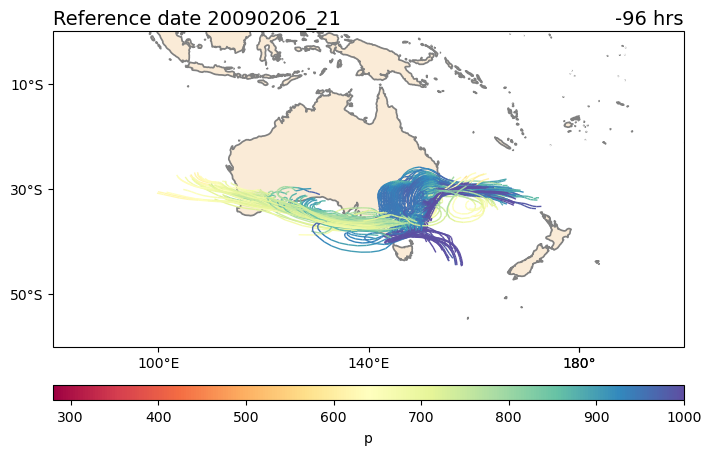

In [52]:
fig = plot_traj(df_traj, # pandas dataframe of trajectory
                'p',     # variable colored along trajectory
                280,     # minimun of variable value
                1000,    # maximum of variable value
                80,      # lon_min
                200,     # lon_max
                -60,     # lat_min
                0,       # lat_max
                'Spectral', # color map
                f'Reference date {reference_datetime_str}',          # upper left title, default - a string of reference date
                f'{period} hrs'                                      # upper right title, default - period (in hours) trajectories calcualted
               ) 

In [53]:
anim_track = animate_traj(df_traj, # pandas dataframe of trajectory
                          'p',     # variable colored along trajectory
                          280,     # minimun of variable value
                          1000,    # maximum of variable value
                          80,      # lon_min
                          200,     # lon_max
                          -60,     # lat_min
                          0,       # lat_max
                          125,     # frames 
                          'Spectral', # color map
                          reference_datetime_str) # a string of reference date
HTML(anim_track.to_jshtml())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>
